In [ ]:
import torch
import numpy as np
import pandas as pd
import math
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


In [ ]:
pic_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Picture embedding using resNet

In [ ]:
resnet20 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [ ]:
modules = list(resnet20.children())[:-1]
resModel = torch.nn.Sequential(*modules)
resModel.eval()
for p in resnet20.parameters():
    p.requires_grad = False

In [ ]:
emb_pic = []
for x, y in trainset:
  emb_pic.append(resModel(x.unsqueeze(dim=0)))

In [ ]:
emb_pic[1].shape

torch.Size([1, 64, 1, 1])

In [ ]:
emb_test_pic=[]
for x, y in testset:
  emb_test_pic.append(resModel(x.unsqueeze(dim=0)))

In [ ]:
len(emb_test_pic)

10000

Text embedding using glove

In [ ]:
from gensim.models import Word2Vec, keyedvectors
import gensim.downloader as api
from gensim.utils import tokenize

In [ ]:
glvModel = api.load("glove-twitter-25")

Question building

In [ ]:
questions = [f'is this a {c}' for c in pic_classes]
questions

['is this a plane',
 'is this a car',
 'is this a bird',
 'is this a cat',
 'is this a deer',
 'is this a dog',
 'is this a frog',
 'is this a horse',
 'is this a ship',
 'is this a truck']

Embedding questions

In [ ]:
tokenized_qs = []
for q in questions:
  tokenized_qs.append(list(tokenize(q, deacc = True)))

In [ ]:
tokenized_qs

[['is', 'this', 'a', 'plane'],
 ['is', 'this', 'a', 'car'],
 ['is', 'this', 'a', 'bird'],
 ['is', 'this', 'a', 'cat'],
 ['is', 'this', 'a', 'deer'],
 ['is', 'this', 'a', 'dog'],
 ['is', 'this', 'a', 'frog'],
 ['is', 'this', 'a', 'horse'],
 ['is', 'this', 'a', 'ship'],
 ['is', 'this', 'a', 'truck']]

In [ ]:
embedded_qs = []

for v in tokenized_qs:
  qemb = 0
  for i in v:
    qemb += glvModel[i]
  embedded_qs.append(qemb / len(v))

In [ ]:
embedded_qs[0].shape

(25,)

In [ ]:
len(embedded_qs)

10

In [ ]:
embedded_qs[0]

array([-0.21787749,  0.19220999,  0.22087625, -0.09129001, -0.29980624,
       -0.05486101,  1.002958  ,  0.18978249, -0.29033002, -0.160615  ,
        0.04531001, -0.05379147, -5.1006503 ,  0.0692675 ,  0.47648   ,
        0.367065  ,  0.28904748,  0.17231825, -0.37730676, -0.10517975,
       -0.0454545 , -0.167205  ,  0.4692725 , -0.408238  , -0.085658  ],
      dtype=float32)

In [ ]:
train_pic_q = []  # pairs of each sample image with each of the 10 questions
for emb_pic_sample in emb_pic:
  for question in embedded_qs:
    train_pic_q.append(torch.cat([torch.tensor(question), emb_pic_sample.squeeze()]))

In [ ]:
len(train_pic_q)

500000

In [ ]:
test_pic_q = []   # pairs of each sample image with each of the 10 questions
for emb_pic_sample in emb_test_pic:
  for question in embedded_qs:
    test_pic_q.append(torch.cat([torch.tensor(question), emb_pic_sample.squeeze()]))
print(len(test_pic_q))

100000


Building answers

In [ ]:
yes_answers = [f'yes it is a {c}' for c in pic_classes]
no_answer = 'no it is not'

In [ ]:
yes_answers

['yes it is a plane',
 'yes it is a car',
 'yes it is a bird',
 'yes it is a cat',
 'yes it is a deer',
 'yes it is a dog',
 'yes it is a frog',
 'yes it is a horse',
 'yes it is a ship',
 'yes it is a truck']

In [ ]:
train_answers = []
for x, y in trainset:
  ans = [no_answer] * len(pic_classes)
  ans[y] = yes_answers[y]
  train_answers.append(ans)

In [ ]:
test_answers=[]
for x, y in testset:
  ans = [no_answer] * len(pic_classes)
  ans[y] = yes_answers[y]
  test_answers.append(ans)

In [ ]:
tok_train_ans= []
for sample in range(len(train_answers)):
  tok_train_ans.append([])
  for answer in range(len(train_answers[sample])):
    tok_train_ans[sample].append(list(tokenize(train_answers[sample][answer], deacc = True)))
print(len(tok_train_ans))

50000


In [ ]:
tok_train_ans[0]

[['no', 'it', 'is', 'not'],
 ['no', 'it', 'is', 'not'],
 ['no', 'it', 'is', 'not'],
 ['no', 'it', 'is', 'not'],
 ['no', 'it', 'is', 'not'],
 ['no', 'it', 'is', 'not'],
 ['yes', 'it', 'is', 'a', 'frog'],
 ['no', 'it', 'is', 'not'],
 ['no', 'it', 'is', 'not'],
 ['no', 'it', 'is', 'not']]

In [ ]:
tok_test_ans= []
for sample in range(len(test_answers)):
  tok_test_ans.append([])
  for answer in range(len(test_answers[sample])):
    tok_test_ans[sample].append(list(tokenize(test_answers[sample][answer], deacc = True)))

In [ ]:
emb_train_ans=[]

for sample in tok_train_ans:
  emb_train_ans.append([])
  for answer in sample:
    aemb = 0
    for token in answer:
      aemb += glvModel[token]
    emb_train_ans[-1].append(aemb/len(answer))

In [ ]:
emb_train_as = []
for sample in emb_train_ans:
  for answer in sample:
    emb_train_as.append(answer) 

In [ ]:
len(emb_train_as[0])

25

In [ ]:
emb_test_ans=[]

for sample in tok_test_ans:
  emb_test_ans.append([])
  for answer in sample:
    aemb = 0
    for token in answer:
      aemb += glvModel[token]
    emb_test_ans[-1].append(aemb/len(answer))

In [ ]:
emb_test_as = []
for sample in emb_test_ans:
  for answer in sample:
    emb_test_as.append(answer) 

In [ ]:
len(emb_test_as)

100000

In [ ]:
train_pic_class = torch.tensor([y for x, y in trainset])
train_pic_class = train_pic_class.repeat_interleave(len(pic_classes))
train_pic_class

tensor([6, 6, 6,  ..., 1, 1, 1])

In [ ]:
train_pic_class.shape

torch.Size([500000])

In [ ]:
test_pic_class = torch.tensor([y for x, y in testset])
test_pic_class = test_pic_class.repeat_interleave(len(pic_classes))
test_pic_class

tensor([3, 3, 3,  ..., 7, 7, 7])

In [ ]:
test_pic_class.shape

torch.Size([100000])

Dataset creation

In [ ]:
class VQADataset(Dataset):
    def __init__(self, emb_pic_q, emb_ans, pic_class):
        self.emb_pic_q = train_pic_q
        self.emb_ans = emb_train_as
        self.pic_class = pic_class
        self.n_samples = len(emb_pic_q)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        return self.emb_pic_q[index], self.emb_ans[index], self.pic_class[index]

In [ ]:
train_dataset = VQADataset(train_pic_q, emb_train_as, train_pic_class)
test_dataset = VQADataset(test_pic_q, emb_test_as, test_pic_class)

In [ ]:
train_pic_class[:20]

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [ ]:
train_pic_q[10]

tensor([-0.2179,  0.1922,  0.2209, -0.0913, -0.2998, -0.0549,  1.0030,  0.1898,
        -0.2903, -0.1606,  0.0453, -0.0538, -5.1007,  0.0693,  0.4765,  0.3671,
         0.2890,  0.1723, -0.3773, -0.1052, -0.0455, -0.1672,  0.4693, -0.4082,
        -0.0857,  0.1847,  0.0295,  0.2482,  0.1475,  2.2291,  0.1675,  2.2573,
         0.1515,  0.3293,  0.3053,  0.1469,  0.4911,  0.2165,  0.0802,  0.9894,
         1.5065,  0.5396,  0.1142,  0.0930,  2.6823,  0.1318,  0.0184,  0.1701,
         0.2608,  0.3817,  0.2402,  0.2279,  0.2171,  0.2667,  0.4629,  0.3271,
         0.4983,  0.0991,  2.7821,  0.1680,  0.4525,  2.5241,  0.3404,  0.3280,
         0.3814,  0.1604,  0.0406,  0.3738,  0.4900,  0.2917,  0.1588,  0.9288,
         0.1740,  0.4397,  0.4218,  0.3777,  1.4796,  2.4290,  0.0629,  0.1168,
         3.8836,  0.0511,  0.2196,  0.7640,  0.0140,  0.0744,  0.4375,  0.2260,
         0.3249])

In [ ]:
len(train_dataset)

500000

In [ ]:
len(test_dataset)

100000

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                                           batch_size=64, shuffle=True,
                                           num_workers=8)
test_loader = DataLoader(dataset=test_dataset,
                                           batch_size=64, shuffle=True,
                                           num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Neural Network

In [ ]:
from torch import nn

In [ ]:
batch_size = 64
num_epochs = 5
num_samples = len(train_dataset)
num_iterations = math.ceil(num_samples / batch_size)
print(num_samples, num_iterations)

500000 7813


In [ ]:
f_net = nn.Sequential(
    nn.Linear(89, 32),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Linear(32, 10)
)
print(f_net)

Sequential(
  (0): Linear(in_features=89, out_features=32, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
g_net = nn.Sequential(
    nn.Linear(25, 16),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    nn.Linear(16, 10)
)
g_net

Sequential(
  (0): Linear(in_features=25, out_features=16, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=16, out_features=10, bias=True)
)

Training

In [ ]:
#device = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
f_net.to(device)
g_net.to(device)

Sequential(
  (0): Linear(in_features=25, out_features=16, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Linear(in_features=16, out_features=10, bias=True)
)

In [ ]:
loss_fn = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(list(f_net.parameters())+list(g_net.parameters()), lr = learning_rate)

In [ ]:
f_net.train()
g_net.train()

for epoch in range(num_epochs):
  for i, (inputs, labels, classes) in enumerate(train_loader):
    #print(labels)
    #print(len(labels))
    #print(labels[0].shape)
    #tensor_input = torch.Tensor(inputs)
    #tensor_label = torch.Tensor(labels)

    inputs, labels = torch.tensor(inputs).to(device), torch.tensor(labels).to(device)
    
    # iq.shape -> (batch_size, 89)
    # a.shape -> (batch_size, 25)
    z_iq = f_net(inputs)
    z_a = g_net(labels)
    loss = loss_fn(z_iq, z_a)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  # w := w - alpha * gradient_w
    
    if i % 1000 == 0:
      print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{num_iterations}, loss={loss:.8f}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


epoch 1/5, step 1/7813, loss=0.21920753
epoch 1/5, step 1001/7813, loss=0.00095285
epoch 1/5, step 2001/7813, loss=0.00048429
epoch 1/5, step 3001/7813, loss=0.00026129
epoch 1/5, step 4001/7813, loss=0.00015992
epoch 1/5, step 5001/7813, loss=0.00008466
epoch 1/5, step 6001/7813, loss=0.00007126
epoch 1/5, step 7001/7813, loss=0.00003940
epoch 2/5, step 1/7813, loss=0.00002582
epoch 2/5, step 1001/7813, loss=0.00001482
epoch 2/5, step 2001/7813, loss=0.00001383
epoch 2/5, step 3001/7813, loss=0.00000730
epoch 2/5, step 4001/7813, loss=0.00000530
epoch 2/5, step 5001/7813, loss=0.00000293
epoch 2/5, step 6001/7813, loss=0.00000244
epoch 2/5, step 7001/7813, loss=0.00000130
epoch 3/5, step 1/7813, loss=0.00000110
epoch 3/5, step 1001/7813, loss=0.00000078
epoch 3/5, step 2001/7813, loss=0.00000052
epoch 3/5, step 3001/7813, loss=0.00000039
epoch 3/5, step 4001/7813, loss=0.00000051
epoch 3/5, step 5001/7813, loss=0.00000021
epoch 3/5, step 6001/7813, loss=0.00000018
epoch 3/5, step 7001

In [ ]:
f_net.eval()
g_net.eval()

z_iqs = []
z_as = []
cs = []

for i, (inputs, labels, classes) in enumerate(train_loader):
  inputs, labels = torch.tensor(inputs).to(device), torch.tensor(labels).to(device)
  # iq.shape -> (batch_size, 89)
  # a.shape -> (batch_size, 25)
  z_iq = f_net(inputs)
  z_a = g_net(labels)

  z_iqs.append(z_iq.detach().cpu())
  z_as.append(z_a.detach().cpu())
  cs.append(classes)

  if i == 100:
    break

z_iqs = torch.cat(z_iqs)
z_as = torch.cat(z_as) 
cs = torch.cat(cs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [ ]:
print(z_iqs.shape)
print(z_as.shape)
print(cs.shape)

torch.Size([6464, 10])
torch.Size([6464, 10])
torch.Size([6464])


In [ ]:
z_as

tensor([[ 0.0141, -0.2696,  0.1167,  ...,  0.1578, -0.0035, -0.1268],
        [ 0.0141, -0.2696,  0.1167,  ...,  0.1578, -0.0035, -0.1268],
        [ 0.0141, -0.2696,  0.1167,  ...,  0.1578, -0.0035, -0.1268],
        ...,
        [ 0.0141, -0.2695,  0.1168,  ...,  0.1578, -0.0035, -0.1268],
        [ 0.0141, -0.2696,  0.1167,  ...,  0.1578, -0.0035, -0.1268],
        [ 0.0141, -0.2696,  0.1167,  ...,  0.1578, -0.0035, -0.1268]])

In [ ]:
z_as_tsne

array([[-1.8089148 , -0.6399786 ],
       [ 1.2652079 , -1.4763324 ],
       [ 0.8558909 , -2.1060715 ],
       ...,
       [-8.358078  , 20.079247  ],
       [-0.9478503 , -1.1843979 ],
       [-0.94780225, -1.184397  ]], dtype=float32)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
%config InlineBackend.figure_format = 'retina'

In [ ]:
z_iqs_tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(z_iqs.numpy())
z_iqs_tsne.shape

(6464, 2)

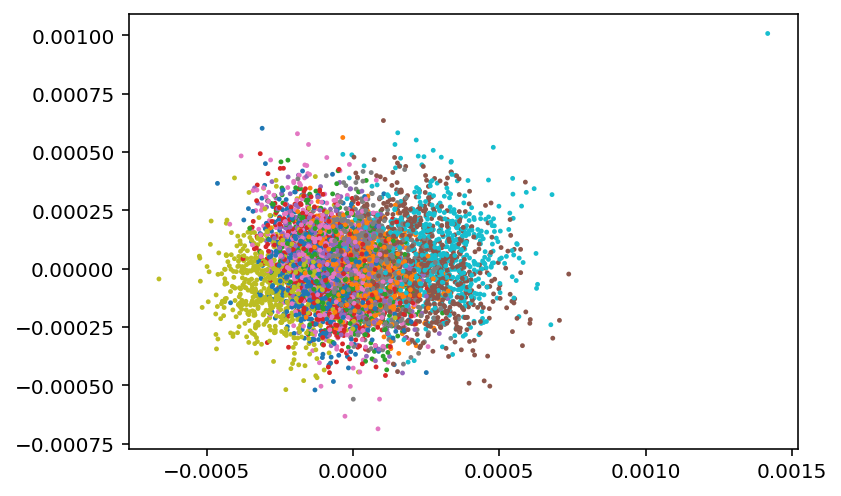

In [ ]:
plt.scatter(z_iqs_tsne[:, 0], z_iqs_tsne[:, 1], s=2, c=cs.numpy(), cmap='tab10')

In [ ]:
z_as_tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(z_as.numpy())
z_as_tsne.shape

(6464, 2)

In [ ]:
z = torch.cat([z_iqs, z_as], dim=0)
total_cs = torch.cat([cs, cs])
z_type = torch.cat([torch.zeros(z_iqs.shape[0]), torch.ones(z_as.shape[0])], dim=0)

In [ ]:
z_tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(z.numpy())
z_tsne.shape

(12928, 2)

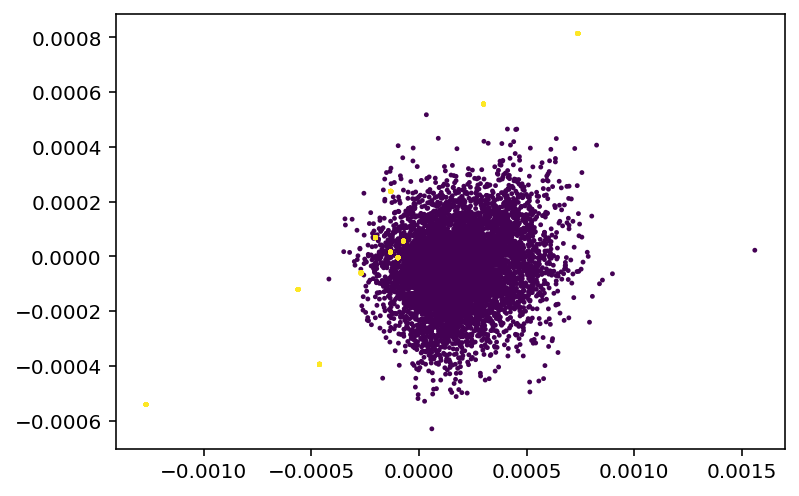

In [ ]:
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], s=2, c=z_type.numpy())

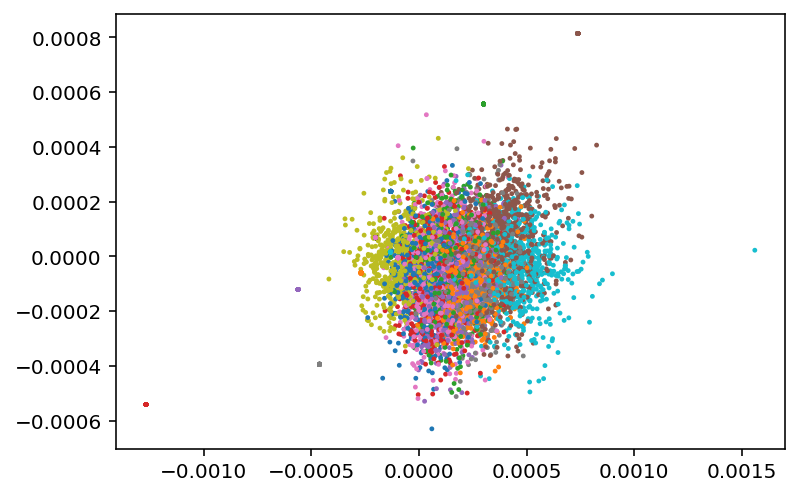

In [ ]:
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], s=2, c=total_cs.numpy(), cmap='tab10')

In [ ]:
z_test=[]
with torch.no_grad():
  for i, (inputs, labels) in enumerate(test_loader):

    inputs, labels = torch.tensor(inputs).to(device), torch.tensor(labels).to(device)
    
    # iq.shape -> (batch_size, 89)
    # a.shape -> (batch_size, 25)
    z_iq = f_net(inputs)
    z_test.append(z_iq)
    z_a = g_net(labels)
    loss = loss_fn(z_iq, z_a)

    
    print(f'step{i+1}/{num_iterations}, inputs{inputs.shape}, loss={loss:.8f}')
    if i ==1000:
      break
z_test=torch.cat(z_test) 

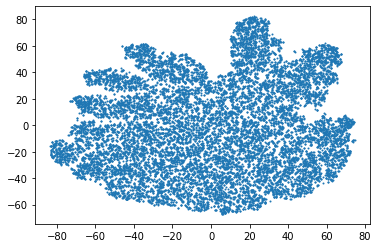

In [ ]:
plt.scatter(z_test_tsne[:, 0], z_test_tsne[:, 1], s=1)